In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from scipy.stats import beta
import seaborn as sns
import matplotlib.pyplot as plt
from tsp import MABandit, thompson_sample

In [2]:
# Init a multi-armed bandit object
success_rates = [0.1, 0.4, 0.45, 0.6, 0.61]
bandit = MABandit(success_rates)
n_bandits = bandit.number_of_arms

In [3]:
# perform Thompson sampling
n_trials = 1000
ab,_ = thompson_sample(bandit, n_trials, seed=3)

## Evolution of the posterior distributions

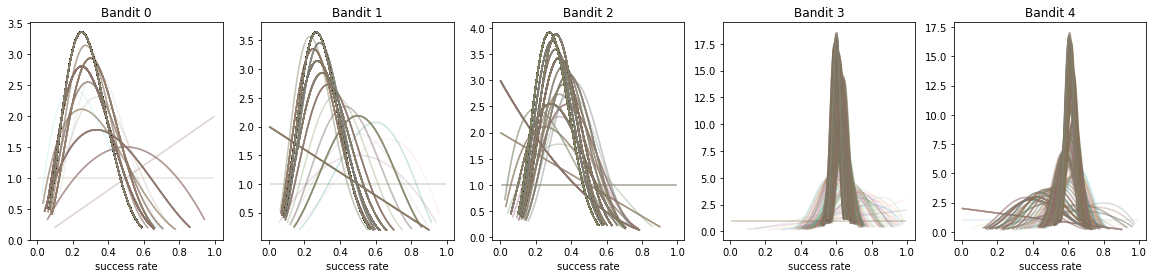

In [63]:
fig, ax = plt.subplots(1,n_bandits, figsize=(20,4))
for bandit in range(n_bandits):
    
    ax[bandit].set(title=f"Bandit {bandit}", xlabel="success rate")
    for trial in range(n_trials):
    
        a = ab[trial, bandit, 0]
        b = ab[trial, bandit, 1]
        x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        
        ax[bandit].plot(x, beta.pdf(x, a, b), '-', alpha=0.1)


The posterior distributions evolve from a uniform to a sharply peaked distribution. As these pictures are quite busy, I also show the final posterior distributions of the success rates in the following:

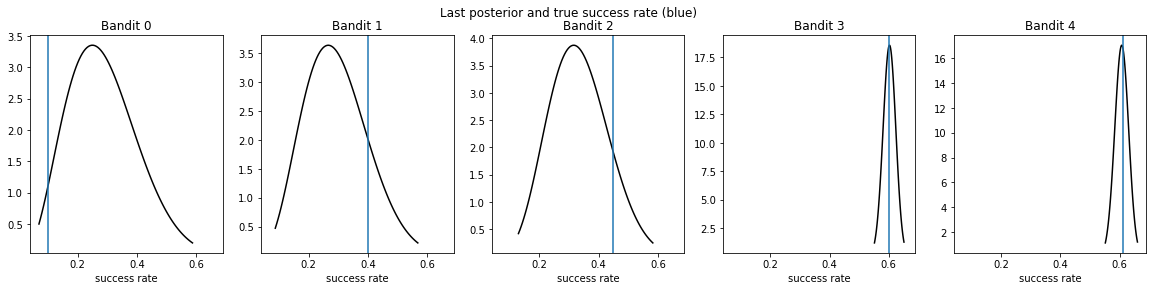

In [64]:
# alternatively, show only the last iteration and the real expected value in comparison
fig, ax = plt.subplots(1,n_bandits, figsize=(20,4), sharex=True)
for bandit in range(n_bandits):
    
    ax[bandit].set(title=f"Bandit {bandit}",
                  xlabel="success rate")
    
    a = ab[-1, bandit, 0]
    b = ab[-1, bandit, 1]
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
        
    ax[bandit].plot(x, beta.pdf(x, a, b), '-', color='black')
    ax[bandit].axvline(x=success_rates[bandit])

fig.suptitle("Last posterior and true success rate (blue) \n")
plt.show()

The tradeoff between exploration and exploitation becomes very clear - as the algorithm quickly favours actions on bandit 3 and 4, the exploration of bandits 0 to 2 does not go so far as to offer good estimates for the real success rates (which is ok, as long as we find the best bandit). One issue we can see is that because the success rates of bandits 3 and 4 are very similar, the algorithm cannot easily find the optimal strategy. I even observed that the algorithm can get stuck with the 2nd best Bandit. In essence, this is an issue of sample size - to resolve an effect between 0.6 and 0.61 the sample size has to be sufficiently large.

## Evolution of point estimates of success rates

In [65]:
# calculate a/a+b for each iteration:
success_estimates = ab[:, :, 0]/(ab[:, :, 0] + ab[:, :, 1])

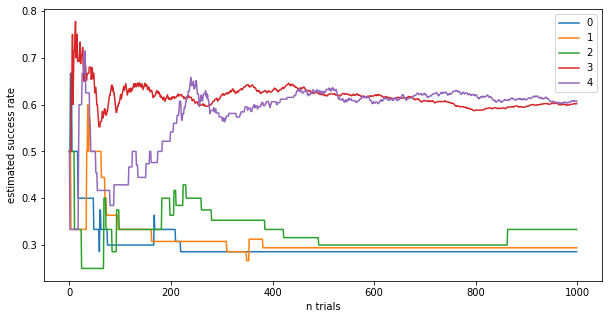

In [66]:
pd.DataFrame(success_estimates).plot(figsize=(10,5), xlabel="n trials", ylabel="estimated success rate")
plt.show()

## Regret

The "per-period" regret of an algorithm over a number of trials is the difference between the mean reward of
an optimal action and the action selected by the algorithm. As we did not consider rewards explicitly, we can reduce this to the difference between the respective success rates.  

If we would show the regret for each time step, the plot would be extremely noisy. To clearly show the decay of regret, we run the simulation several times and average over the single outcomes:

In [67]:
def average_regret(success_rates, n_trials, n_sim):
    """Average the regret over [n_sim] runs of Thompson sampling.
    
    success_rates: np.array with success rates of the slot machines (Bernoulli trials)
    n_trials:      Int, number of actions in Thompson sampling
    n_sim:         Int, number of simulations
    
    return:        np.array of shape (n_trials, 1), contains average regret
    
    """
    sim_results = np.zeros((n_sim, n_trials))
    
    # init multi-armed Bandit
    bandit = MABandit(success_rates)
    # calculate max success rate
    max_rate = np.max(success_rates)
    # convert success_rates to np array (to enable numpy style indexing)
    success_rates_array = np.array(success_rates)
    
    for i in range(n_sim):
        # perform Thompson sampling
        _, played_arms = thompson_sample(bandit, n_trials)
        # calculate regret and store it
        sim_results[i, :] = max_rate - success_rates_array[played_arms.astype(int)]
    
    # calculate the average regret from all simulations
    avg = np.apply_along_axis(lambda x: np.mean(x), 0, sim_results)
    
    return avg

In [68]:
avg_regret = average_regret(success_rates, n_trials=1000, n_sim=1000)

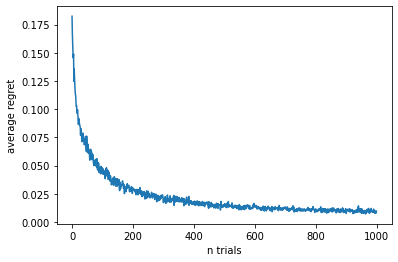

In [69]:
fig, ax = plt.subplots()
ax.plot(avg_regret)
ax.set(xlabel="n trials", ylabel="average regret")
plt.show()

## Some notes on implementation
Initially I intended the tsp package to provide a function for the regret. However, in a real-world application, the true success rates would not be known to the Thompson sampling algorithm! In general, there is a clear separation between the experiment (e.g. comparison of the success of different advertising adds) and the Thompson sampling algorithm itsself. To simulate this external source of success rates I created the MABandit class. The MABandit object could be replaced with any other programmatic object that provides the same methods.   